In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete = load_umachine_sdss_with_meert15()
no_data_mask = np.isnan(full_sdss['Magr_tot_meert15'])

mask = ~no_data_mask & behroozi_complete
sdss = full_sdss[mask]

mask_sf = sdss['ssfr'] >= -10.75
mask_gv = (sdss['ssfr'] < -10.75) & (sdss['ssfr'] >= -11.25)
mask_q = (sdss['ssfr'] < -11.25)

from galsize_models.measurements.sdss_covariance import sdss_measurements_and_cov
sdss_data_vector, sdss_cov = sdss_measurements_and_cov()

In [3]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()
print(mock.keys())

Total runtime = 29.20 seconds
['obs_sfr', 'icl', 'upid', 'mpeak', 'sfr', 'halo_id', 'mvir', 'rvir', 'vmax_at_mpeak', 'vx', 'a_first_infall', 'sm', 'vy', 'y', 'x', 'vz', 'z', 'dvmax_zscore', 'obs_sm', 'halo_hostid', 'host_halo_rvir', 'host_halo_mvir', 'ssfr', 'is_main_sequence', 'is_green_valley', 'is_quenched', 'logsm', 'rvir_halo_kpc', 'spin_at_infall', 'bt_meert15_random']


# Inspect specific model

In [4]:
from galsize_models.models.bulge_disk_double_power_law import data_vector_prediction
from galsize_models.measurements.sdss_covariance import logsm_bins, logsm_mids
from astropy.table import Table 

chain_fname = "bulge_disk_power_law_chain_aggressive_priors.dat"

itest = -1
try:
    chain = Table.read(chain_fname, format='ascii')
    chain.sort('lnprob')
    row = chain[itest]
    params = [row[key] for key in row.colnames if key != 'lnprob']
    norm_bulge, bulge_to_disk_size_ratio, alpha_bulge, alpha_disk, scatter = params
    norm_disk = norm_bulge/bulge_to_disk_size_ratio
    lnprob = row['lnprob']
    print(row)
except:
    norm_bulge = 0.0032
    bulge_to_disk_size_ratio = 0.4143
    alpha_bulge = 1.1449
    alpha_disk = 1.084
    scatter = 0.1059
    params = norm_bulge, bulge_to_disk_size_ratio, alpha_bulge, alpha_disk, scatter
    
model_data_vector = data_vector_prediction(params, mock, logsm_bins)

from galsize_models.models.bulge_disk_double_power_law import galaxy_size_vs_rhalo

rvir_halo_kpc = mock['rvir_halo_kpc']
bt = mock['bt_meert15_random']
mock['r50_magr_kpc_meert15'] = galaxy_size_vs_rhalo(rvir_halo_kpc, bt, norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter)

norm_bulge bulge_to_disk_size_ratio alpha_bulge alpha_disk scatter   lnprob 
---------- ------------------------ ----------- ---------- -------- --------
    0.0041                 0.209532    0.938278   0.975933 0.174694 -3.93291


In [29]:
scatter2 = 0.1
params2 = norm_bulge, bulge_to_disk_size_ratio, alpha_bulge, alpha_disk, scatter2

model_data_vector2 = data_vector_prediction(params2, mock, logsm_bins)
mock['r50_magr_kpc_meert15_alt'] = galaxy_size_vs_rhalo(rvir_halo_kpc, bt, norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter)

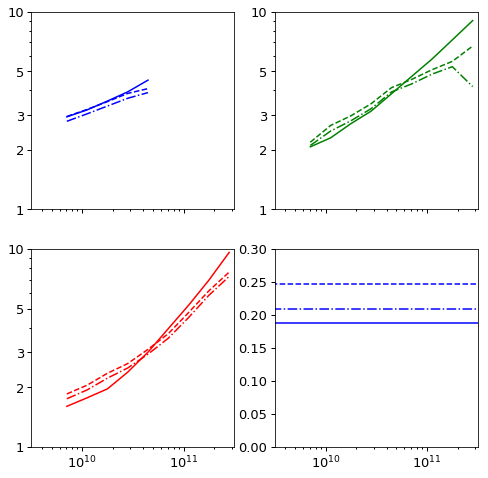

In [30]:
from galsize_models.measurements.sdss_covariance import _get_ifirst_ilast_indices
from matplotlib import ticker

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes
axis_list = (ax1, ax2, ax3, ax4)
__=ax1.loglog(); __=ax2.loglog(); __=ax3.loglog(); __=ax4.set_xscale('log')

for ax in axis_list[:-1]:
    ylim = ax.set_ylim(1, 10)
    __=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_yticks((1, 2, 3, 5, 10))



ifirst, ilast = _get_ifirst_ilast_indices(0)
nskip = ilast-ifirst
__=ax1.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='blue')
__=ax1.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='blue')
__=ax1.plot(10**logsm_mids[:nskip], model_data_vector2[ifirst:ilast], '-.', color='blue')

ifirst, ilast = _get_ifirst_ilast_indices(1)
nskip = ilast-ifirst
__=ax2.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='green')
__=ax2.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='green')
__=ax2.plot(10**logsm_mids[:nskip], model_data_vector2[ifirst:ilast], '-.', color='green')

ifirst, ilast = _get_ifirst_ilast_indices(2)
nskip = ilast-ifirst
__=ax3.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='red')
__=ax3.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='red')
__=ax3.plot(10**logsm_mids[:nskip], model_data_vector2[ifirst:ilast], '-.', color='red')

ifirst, ilast = _get_ifirst_ilast_indices(3)
_x = np.logspace(9, 12, len(logsm_mids))
y_data = np.zeros_like(logsm_mids) + sdss_data_vector[ifirst]
y_model = np.zeros_like(logsm_mids) + model_data_vector[ifirst]
y_model2 = np.zeros_like(logsm_mids) + model_data_vector2[ifirst]
__=ax4.plot(_x, y_data, color='blue')
__=ax4.plot(_x, y_model, '--', color='blue')
__=ax4.plot(_x, y_model2, '-.', color='blue')


for ax in axis_list:
    xlim = ax.set_xlim(10**9.5, 10**11.5)

ylim4 = ax.set_ylim(0, 0.3)


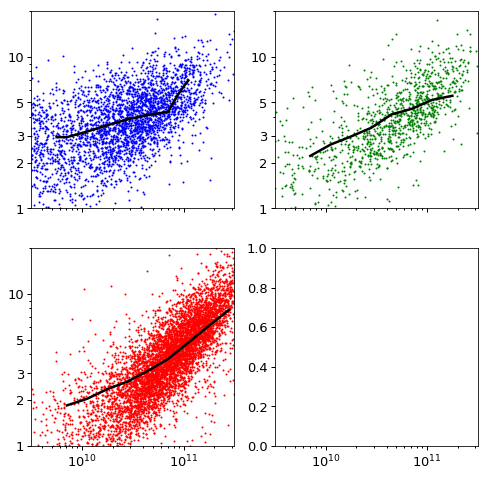

In [81]:
from galsize_models.measurements.sdss_covariance import _get_ifirst_ilast_indices
from matplotlib import ticker

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes
axis_list = (ax1, ax2, ax3, ax4)
__=ax1.loglog(); __=ax2.loglog(); __=ax3.loglog(); __=ax4.set_xscale('log')
for ax in axis_list:
    xlim = ax.set_xlim(10**9.5, 10**11.5)

for ax in axis_list[:-1]:
    ylim = ax.set_ylim(1, 20)
    __=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_yticks((1, 2, 3, 5, 10))

from scipy.stats import binned_statistic

sf_model_size, __, __ = binned_statistic(np.log10(mock['obs_sm'][mock['is_main_sequence']]), 
                                        mock['r50_magr_kpc_meert15_alt'][mock['is_main_sequence']], 
                                         bins=logsm_bins)
gv_model_size, __, __ = binned_statistic(np.log10(mock['obs_sm'][mock['is_green_valley']]), 
                                        mock['r50_magr_kpc_meert15_alt'][mock['is_green_valley']], 
                                         bins=logsm_bins)
q_model_size, __, __ = binned_statistic(np.log10(mock['obs_sm'][mock['is_quenched']]), 
                                        mock['r50_magr_kpc_meert15_alt'][mock['is_quenched']], 
                                         bins=logsm_bins)

x = np.linspace(9.75, 11.5, 500)
y = np.interp(x, logsm_mids, sf_model_size)

__=ax1.plot(10**x, y, color='k', lw=2.5)
__=ax1.scatter(10**sdss['sm'][mask_sf][::20], 
               sdss['r50_magr_kpc_meert15'][mask_sf][::20], 
              s=1, color='blue')

__=ax2.plot(10**(logsm_mids[:-1]), gv_model_size[:-1], color='k', lw=2.5)
__=ax2.scatter(10**sdss['sm'][mask_gv][::20], 
               sdss['r50_magr_kpc_meert15'][mask_gv][::20], 
              s=1, color='green')

__=ax3.plot(10**(logsm_mids), q_model_size, color='k', lw=2.5)
__=ax3.scatter(10**sdss['sm'][mask_q][::20], 
               sdss['r50_magr_kpc_meert15'][mask_q][::20], 
              s=1, color='red')


# ifirst, ilast = _get_ifirst_ilast_indices(3)
# _x = np.logspace(9, 12, len(logsm_mids))
# y_data = np.zeros_like(logsm_mids) + sdss_data_vector[ifirst]
# y_model = np.zeros_like(logsm_mids) + model_data_vector[ifirst]
# y_model2 = np.zeros_like(logsm_mids) + model_data_vector2[ifirst]
# __=ax4.plot(_x, y_data, color='blue')
# __=ax4.plot(_x, y_model, '--', color='blue')
# __=ax4.plot(_x, y_model2, '-.', color='blue')


# Check effect of CAM with spin

In [31]:
mock['r50_magr_kpc_meert15_cam'] = np.copy(mock['r50_magr_kpc_meert15_alt'])
log_mpeak_bins = np.linspace(11.5, 14.5, 25)
for low, high in zip(log_mpeak_bins[:-1], log_mpeak_bins[1:]):
    sm_mask = (mock['mpeak'] > 10**low) & (mock['mpeak'] < 10**high)
    mask = sm_mask & (mock['ssfr'] > -10.75)
    sample = mock[mask]
    idx_sorted = np.argsort(sample['spin_at_infall']) 
    sorted_r50 = sample['r50_magr_kpc_meert15'][idx_sorted]
    mock['r50_magr_kpc_meert15_cam'][mask] = sorted_r50

In [34]:
from galsize_models.measurements import wp_ssfr_sequence_mock
logsm_min = 10.25
ssfr_sample = 'sf'

result1 = wp_ssfr_sequence_mock(mock, logsm_min, ssfr_sample, size_key='r50_magr_kpc_meert15_alt')
rp_mids, wp_sm, wp_sm_small, wp_sm_large = result1

result2 = wp_ssfr_sequence_mock(mock, logsm_min, ssfr_sample, size_key='r50_magr_kpc_meert15_cam')
rp_mids, wp_sm_cam, wp_sm_small_cam, wp_sm_large_cam = result2

fracdiff = (wp_sm_large - wp_sm_small)/wp_sm
fracdiff_cam = (wp_sm_large_cam - wp_sm_small_cam)/wp_sm_cam

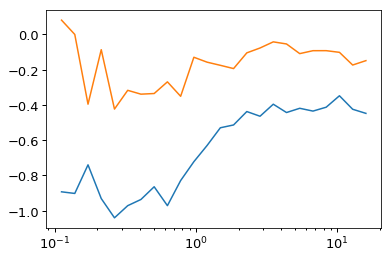

In [35]:
fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')

__=ax.plot(rp_mids, fracdiff, label='no spin correlation')
__=ax.plot(rp_mids, fracdiff_cam, label='max spin correlation')

